In [1]:
import os
import gensim 
from gensim.parsing.preprocessing import remove_stopwords
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec 
import gensim.downloader as api
from gensim import corpora
from scipy import spatial
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial import distance   
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from gensim import corpora
import re

In [2]:
def clean_sentence(sentence, stopwords=False): 
    sentence = sentence.lower().strip()
    sentence = re.sub(r'[^a-z0-9\s]', '', sentence)    
    if stopwords:
         sentence = remove_stopwords(sentence)

    return sentence
                    
def get_cleaned_sentences(df,stopwords=False):    
    sents=df[["questions"]];
    cleaned_sentences=[]
    for index,row in df.iterrows():
        cleaned=clean_sentence(row["questions"],stopwords);
        cleaned_sentences.append(cleaned);
    return cleaned_sentences;


def retrieveAndPrintFAQAnswer(question_embedding,sentence_embeddings,FAQdf,sentences):
    max_sim=-1;
    index_sim=-1;
    for index,faq_embedding in enumerate(sentence_embeddings):
        sim=cosine_similarity(faq_embedding,question_embedding)[0][0];
        if sim>max_sim:
            max_sim=sim;
            index_sim=index;
            
    return(FAQdf.iloc[index_sim,1])


def getWordVec(word,model):
        samp=model['model'];
        vec=[0]*len(samp);
        try:
                vec=model[word];
        except:
                vec=[0]*len(samp);
        return (vec)


def getPhraseEmbedding(phrase,embeddingmodel):       
        samp=getWordVec('model', embeddingmodel);
        vec=np.array([0]*len(samp));
        den=0;
        for word in phrase.split():
            #print(word)
            den=den+1;
            vec=vec+np.array(getWordVec(word,embeddingmodel));
        
        return vec.reshape(1, -1)


In [3]:
def cosine_distance_countvectorizer_method(s1, s2):
    # sentences to list
    allsentences = [s1 , s2]
    # text to vector
    vectorizer = CountVectorizer()
    all_sentences_to_vector = vectorizer.fit_transform(allsentences)
    text_to_vector_v1 = all_sentences_to_vector.toarray()[0].tolist()
    text_to_vector_v2 = all_sentences_to_vector.toarray()[1].tolist()
    
    # distance of similarity
    cosine = spatial.distance.cosine(text_to_vector_v1, text_to_vector_v2)
    print('Similarity of two sentences are equal to ',round((1-cosine)*100,2),'%')
    return round((1-cosine)*100,2)
    #return cosine

def preprocess(raw_text):
    # keep only words
    letters_only_text = re.sub("[^a-zA-Z]", " ", raw_text)
    # convert to lower case and split 
    words = letters_only_text.lower().split()
    # remove stopwords
    stopword_set = set(stopwords.words("english"))
    cleaned_words = list(set([w for w in words if w not in stopword_set]))
    return cleaned_words

def cosine_distance_between_two_words(word1, word2,model):
    return (1- scipy.spatial.distance.cosine(model[word1], model[word2]))

def calculate_heat_matrix_for_two_sentences(s1,s2,model):
    s1 = preprocess(s1)
    s2 = preprocess(s2)
    result_list = [[cosine_distance_between_two_words(word1, word2,model) for word2 in s2] for word1 in s1]
    result_df = pd.DataFrame(result_list)
    result_df.columns = s2
    result_df.index = s1
    return result_df

def cosine_distance_wordembedding_method(s1, s2,model):
    vector_1 = np.mean([model[word] for word in preprocess(s1)],axis=0)
    vector_2 = np.mean([model[word] for word in preprocess(s2)],axis=0)
    cosine = scipy.spatial.distance.cosine(vector_1, vector_2)
    print('Word Embedding method with a cosine distance asses that our two sentences are similar to',round((1-cosine)*100,2),'%')
    return round((1-cosine)*100,2)

def heat_map_matrix_between_two_sentences(s1,s2,model):
    df = calculate_heat_matrix_for_two_sentences(s1,s2,model)
    
    fig, ax = plt.subplots(figsize=(5,5)) 
    ax_blue = sns.heatmap(df, cmap="YlGnBu")
    temp = cosine_distance_wordembedding_method(s1, s2,model)
    return ax_blue, temp

In [4]:

def avg_feature_vector(sentence, model, num_features, index2word_set):
    words = sentence.split()
    feature_vec = np.zeros((num_features, ), dtype='float32')
    n_words = 0
    for word in words:
        if word in index2word_set:
            n_words += 1
            feature_vec = np.add(feature_vec, model[word])
    if (n_words > 0):
        feature_vec = np.divide(feature_vec, n_words)
    return feature_vec




In [7]:
def model(temp, temp2, v2w_model):
    temp = str(temp)
    temp2 = str(temp2)
    
    df = pd.read_csv("./Book1.csv", encoding= 'unicode_escape')

    cleaned_sentences=get_cleaned_sentences(df,stopwords=True)
    cleaned_sentences_with_stopwords=get_cleaned_sentences(df,stopwords=False)
    sentences=cleaned_sentences_with_stopwords
    # Split it by white space 
    sentence_words = [[word for word in document.split() ]
            for document in sentences]


    dictionary = corpora.Dictionary(sentence_words)

    question_orig=temp
    question=clean_sentence(question_orig,stopwords=False);
    question_embedding = dictionary.doc2bow(question.split())
    cleaned_sentences=get_cleaned_sentences(df,stopwords=True)
    
    
    sent_embeddings=[];

    for sent in cleaned_sentences:
        sent_embeddings.append(getPhraseEmbedding(sent,v2w_model));

    question_embedding=getPhraseEmbedding(question,v2w_model);
    
    x = retrieveAndPrintFAQAnswer(question_embedding,sent_embeddings,df, cleaned_sentences);
    print("-----------------------------------------------------------------------------------------------------")
    print("Asked Question")
    print(temp)
    print("Original Answer")
    print(temp2)
    print("Given Answer")
    print(x)
    print("-----------------------------------------------------------------------------------------------------")
    similarity_w2v = heat_map_matrix_between_two_sentences(temp2,x, v2w_model)
    return similarity_w2v
    


In [8]:
v2w_model=None;
try:
    v2w_model = gensim.models.KeyedVectors.load("./w2vecmodel.mod")
    print("Loaded w2v model")
except:            
    v2w_model = api.load('word2vec-google-news-300')
    v2w_model.save("./w2vecmodel.mod")

my_dict = {}


Loaded w2v model


In [9]:
glove_model=None;
try:
    glove_model = gensim.models.KeyedVectors.load("./glovemodel.mod")
    print("Loaded glove model")
except:            
    glove_model = api.load('glove-twitter-25')
    glove_model.save("./glovemodel.mod")
    print("Saved glove model")


Loaded glove model


# w2v

-----------------------------------------------------------------------------------------------------
Asked Question
In three or less sentences, explain the Holocaust
Original Answer
killing of jews by nazis during world war
Given Answer
During the Second World War, the Nazis murdered nearly six million European Jews. This genocide is called the Holocaust.
-----------------------------------------------------------------------------------------------------
Word Embedding method with a cosine distance asses that our two sentences are similar to 85.86 %
-----------------------------------------------------------------------------------------------------
Asked Question
Explain what Corona 19 is and what the abbreviation stands for
Original Answer
a new virus which affects badly and there is no treatment yet.
Given Answer
The coronavirus, is inciting panic for a number of reasons. It's a new virus, meaning no one has immunity, and there is no vaccine. Its novelty means that scientists aren

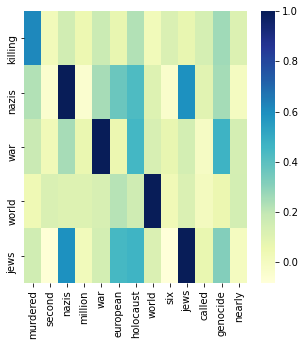

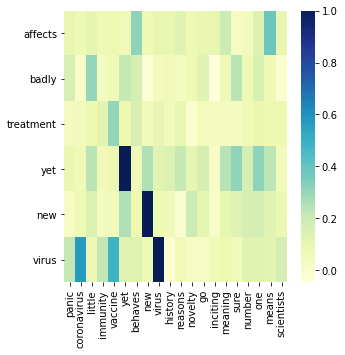

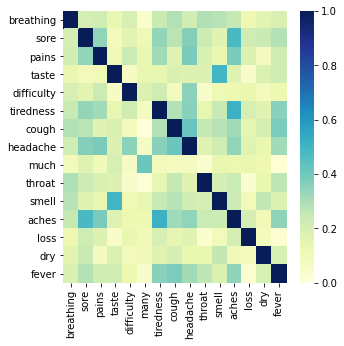

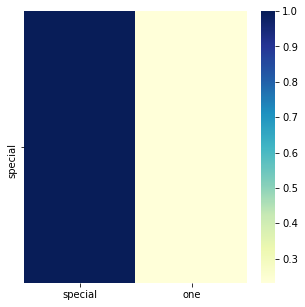

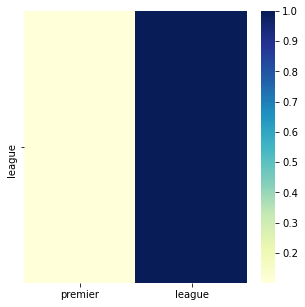

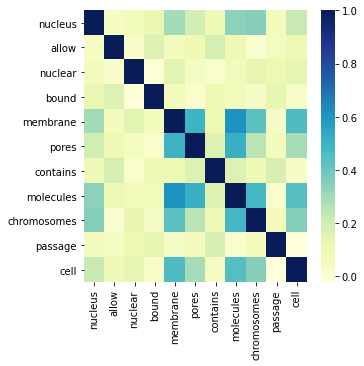

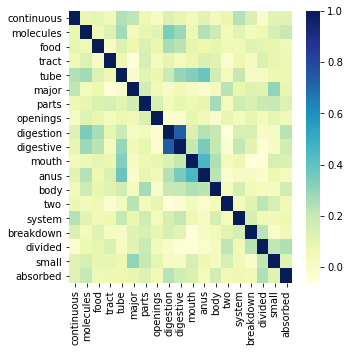

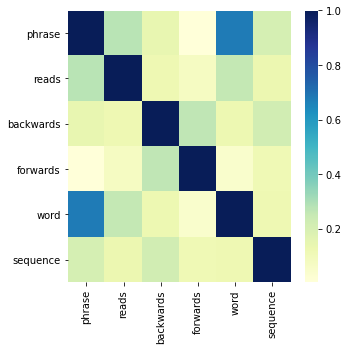

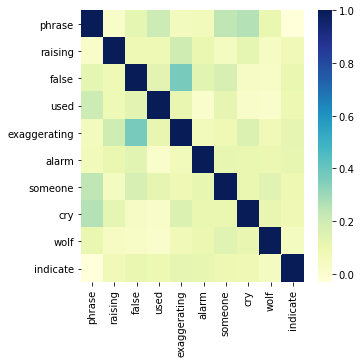

In [10]:
file=pd.read_csv("160539.csv", encoding= 'unicode_escape');
list_calc = []
for ind in file.index:
    similarity_w2v = model(file['question'][ind], file['answer'][ind], v2w_model)
    list_calc.append(similarity_w2v[1])



In [11]:
list_calc

[85.86, 67.11, 99.62, 87.48, 74.99, 100.0, 100.0, 100.0, 100.0]

In [12]:
list_acc = []
list_std = []
mean = sum(list_calc) / len(list_calc)
variance = sum([((x - mean) ** 2) for x in list_calc]) / len(list_calc)
res = variance ** 0.5

list_std.append(res)
# Printing result
print("Standard deviation of sample is : " + str(res))

Standard deviation of sample is : 11.843618795488121


In [13]:
sum_v2w = sum(list_calc)/len(list_calc)
print("Percentage", sum_v2w)
list_acc.append(sum_v2w)

Percentage 90.56222222222222


# glove

-----------------------------------------------------------------------------------------------------
Asked Question
In three or less sentences, explain the Holocaust
Original Answer
killing of jews by nazis during world war
Given Answer
The coronavirus, is inciting panic for a number of reasons. It's a new virus, meaning no one has immunity, and there is no vaccine. Its novelty means that scientists aren't sure yet how it behaves they have little history to go on.
-----------------------------------------------------------------------------------------------------
Word Embedding method with a cosine distance asses that our two sentences are similar to 84.17 %
-----------------------------------------------------------------------------------------------------
Asked Question
Explain what Corona 19 is and what the abbreviation stands for
Original Answer
a new virus which affects badly and there is no treatment yet.
Given Answer
The coronavirus, is inciting panic for a number of reasons.

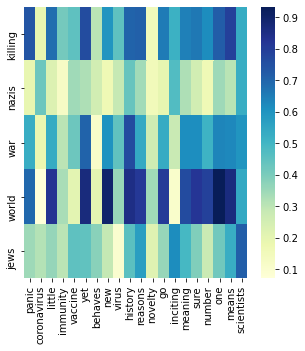

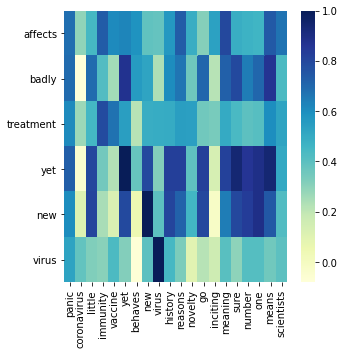

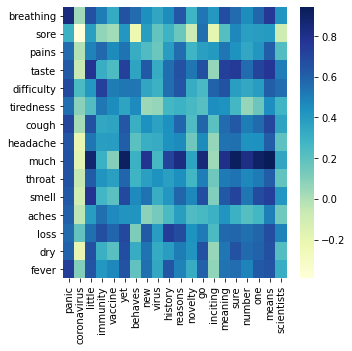

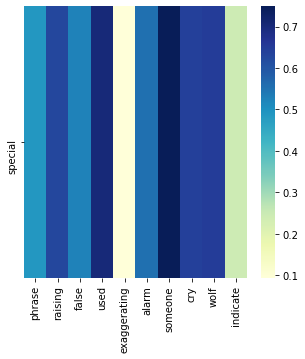

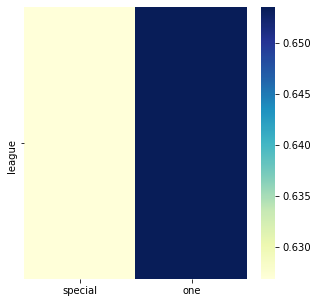

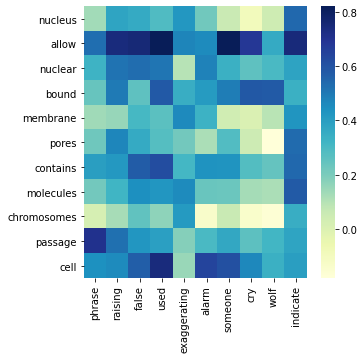

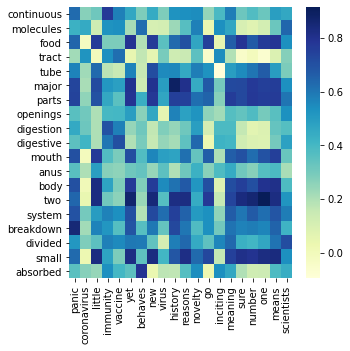

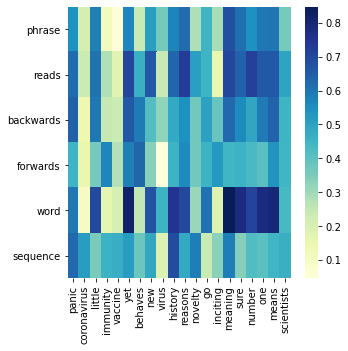

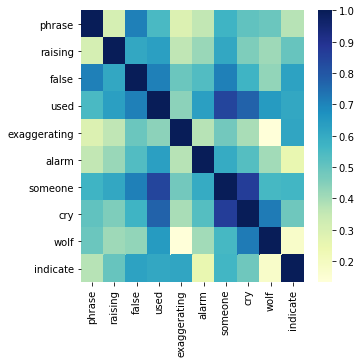

In [14]:
file=pd.read_csv("160539.csv", encoding= 'unicode_escape');
list_calc2 = []
for ind in file.index:
    similarity_w2v = model(file['question'][ind], file['answer'][ind], glove_model)
    list_calc2.append(similarity_w2v[1])



In [15]:
list_calc2

[84.17, 95.99, 78.29, 71.38, 66.85, 71.49, 90.25, 87.88, 100.0]

In [16]:
mean = sum(list_calc2) / len(list_calc2)
variance = sum([((x - mean) ** 2) for x in list_calc2]) / len(list_calc2)
res = variance ** 0.5

list_std.append(res)
# Printing result
print("Standard deviation of sample is : " + str(res))

Standard deviation of sample is : 10.984547507777336


In [17]:
sum_glove = sum(list_calc2)/len(list_calc2)
print("Percentage", sum_glove)
list_acc.append(sum_glove)

Percentage 82.92222222222222


# bow

In [18]:
## import numpy
def model(temp, temp2):
    temp = str(temp)
    temp2 = str(temp2)
    df=pd.read_csv("Book1.csv", encoding= 'unicode_escape');

    cleaned_sentences=get_cleaned_sentences(df,stopwords=True)
    #print(cleaned_sentences);

    print("\n")

    #printing cleaned sentences without removal of stopwords
    cleaned_sentences_with_stopwords=get_cleaned_sentences(df,stopwords=False)
    print(cleaned_sentences_with_stopwords);

    #using cleaned sentences with stopwords here
    sentences=cleaned_sentences_with_stopwords

    # Split it by white space 
    sentence_words = [[word for word in document.split() ]
             for document in sentences]


    #corpora is a lightweight, fast and scalable corpus library able to store a collection 
    #of raw text documents with additional key-value headers
    dictionary = corpora.Dictionary(sentence_words)
    
    #calculating sentence embedding for bow embedding
    bow_corpus = [dictionary.doc2bow(text) for text in sentence_words]
    

    #now calculating the question embedding
    question_orig=temp
    question=clean_sentence(question_orig,stopwords=False);
    question_embedding = dictionary.doc2bow(question.split())

    x = retrieveAndPrintFAQAnswer(question_embedding,bow_corpus,df,cleaned_sentences);
    print("-----------------------------------------------------------------------------------------------------")
    print("Asked Question")
    print(temp)
    print("Original Answer")
    print(temp2)
    print("Given Answer")
    print(x)
    print("-----------------------------------------------------------------------------------------------------")

    similarity_w2v = heat_map_matrix_between_two_sentences(temp2,x, v2w_model)
    return similarity_w2v



['in three or less sentences explain the holocaust', 'explain what corona 19 is and what the abbreviation stands for', 'explain some of the symptoms of corona 19', 'in football what nickname does jose mourinho refer to himself as and why', 'what was significant about mario balotellis only assist in the premier league for manchester city', 'in biology what is the nucleus and what does it do', 'what is the role of disgestive system', 'what is a palindrome', 'what does the saying dont cry wolf imply']
-----------------------------------------------------------------------------------------------------
Asked Question
In three or less sentences, explain the Holocaust
Original Answer
killing of jews by nazis during world war
Given Answer
During the Second World War, the Nazis murdered nearly six million European Jews. This genocide is called the Holocaust.
-----------------------------------------------------------------------------------------------------
Word Embedding method with a cosi

Word Embedding method with a cosine distance asses that our two sentences are similar to 33.16 %


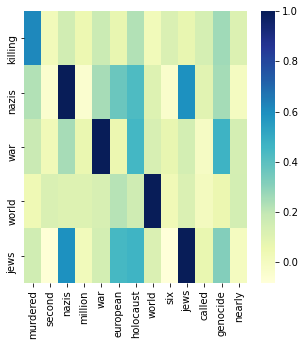

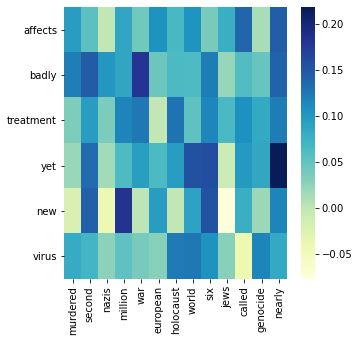

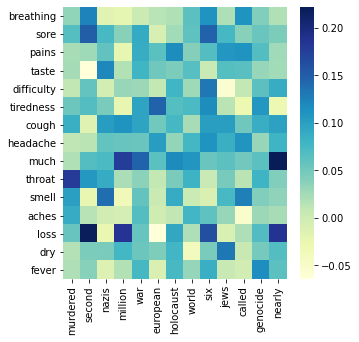

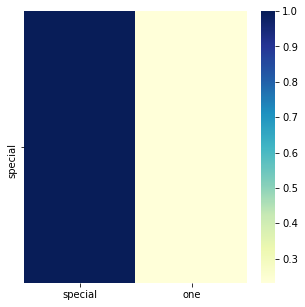

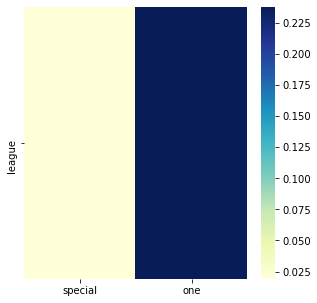

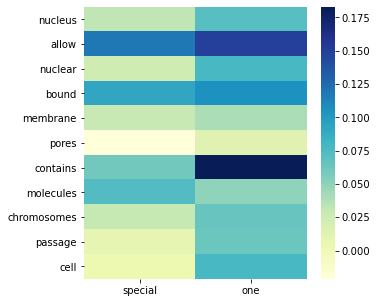

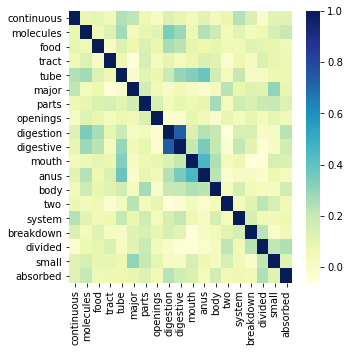

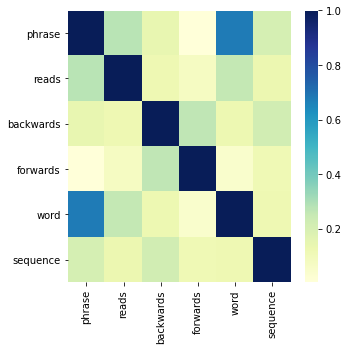

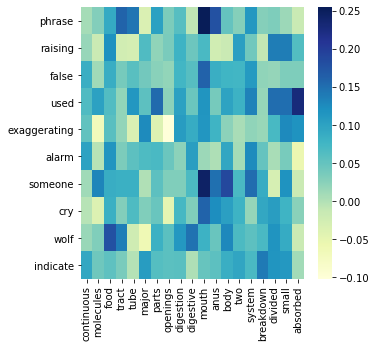

In [19]:
file=pd.read_csv("160539.csv", encoding= 'unicode_escape');
list_calc3 = []
for ind in file.index:
    temp = model(file['question'][ind], file['answer'][ind])
    list_calc3.append(temp[1])



In [20]:
list_calc3

[85.86, 29.64, 21.67, 87.48, 13.3, 12.77, 100.0, 100.0, 33.16]

In [21]:
mean = sum(list_calc3) / len(list_calc3)
variance = sum([((x - mean) ** 2) for x in list_calc3]) / len(list_calc3)
res = variance ** 0.5

list_std.append(res)
# Printing result
print("Standard deviation of sample is : " + str(res))

Standard deviation of sample is : 36.204385281071225


In [22]:
sum_bow = sum(list_calc3)/len(list_calc3)
print("Percentage", sum_bow)
list_acc.append(sum_bow)

Percentage 53.76444444444444


In [23]:
#plotting std
standard_list = [0,10,20,30,40,50,60,70,80,90]
index = ['Word2Vec', 'Glove', 'Bag of Words']

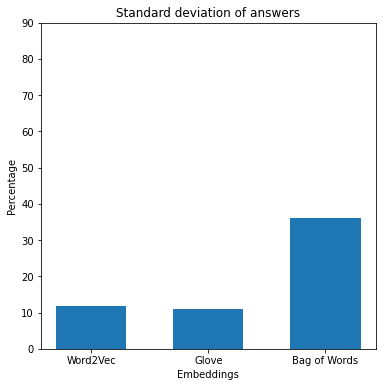

In [24]:
fig = plt.figure(figsize = (6, 6))
# creating the bar plot
plt.bar(index, list_std, width = 0.6)
plt.xticks(index)
plt.yticks(standard_list)
plt.xlabel("Embeddings")
plt.ylabel("Percentage")
plt.title("Standard deviation of answers")
plt.show()

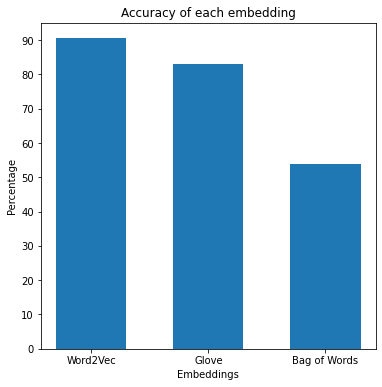

In [25]:
fig = plt.figure(figsize = (6, 6))
# creating the bar plot
plt.bar(index, list_acc, width = 0.6)
plt.xticks(index)
plt.yticks(standard_list)
plt.xlabel("Embeddings")
plt.ylabel("Percentage")
plt.title("Accuracy of each embedding")
plt.show()